In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


In [2]:
sns.set(style='darkgrid')

mpl.rcParams['figure.figsize'] = (16,9)
pd.set_option('display.max_rows', 500)

In [3]:
dataPath_Processed = ("../data/processed/COVID_Flat_Table_small.csv")

In [4]:
df_analyse = pd.read_csv(dataPath_Processed, sep=',')

In [5]:
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,India,"Korea, South",China,Brazil,United Kingdom
0,2020-01-22,0,1,0,0,0,1,548,0,0
1,2020-01-23,0,1,0,0,0,1,643,0,0
2,2020-01-24,0,2,0,0,0,2,920,0,0
3,2020-01-25,0,2,0,0,0,2,1406,0,0
4,2020-01-26,0,5,0,0,0,3,2075,0,0


In [68]:
country = 'India'

N0 = 1000000
beta = 0.4
gamma = 0.1

I0 = 90
S0 = N0-I0
R0 = 0

In [69]:
def SIR_model(SIR,beta, gamma):
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I
    
    return([dS_dt,dI_dt,dR_dt])

In [70]:
SIR = np.array([S0,I0,R0])

propagation_rate = pd.DataFrame(columns={'Susceptible':S0,
                                        'Infected':I0,
                                        'Recovered':R0
                                        })

for each_t in np.arange(50):
    
    new_delta_vec = SIR_model(SIR,beta,gamma)
    SIR = SIR + new_delta_vec
    propagation_rate = propagation_rate.append({'Susceptible':SIR[0],
                                        'Infected':SIR[1],
                                        'Recovered':SIR[2]
                                        }, ignore_index = True)

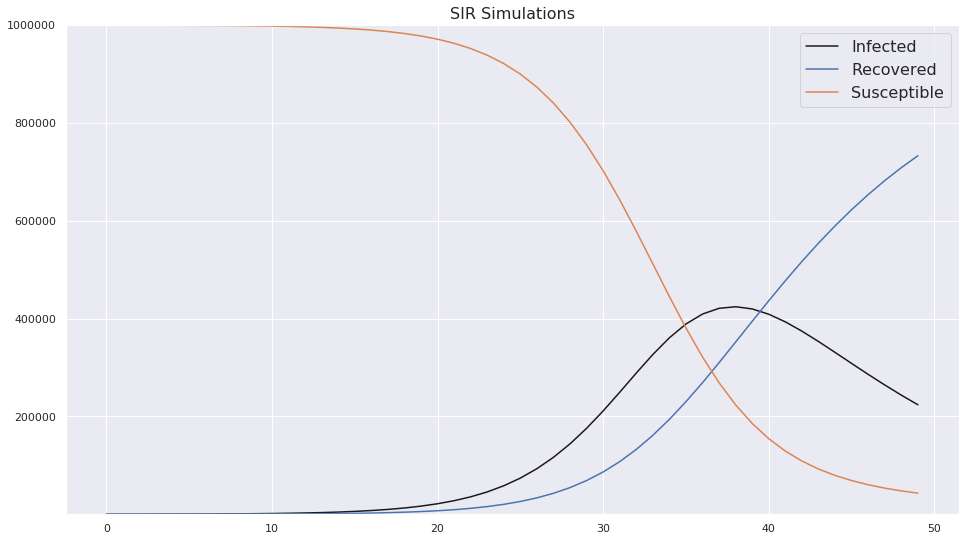

In [71]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rate.index, propagation_rate.Infected, label='Infected', color='k')
ax1.plot(propagation_rate.index, propagation_rate.Recovered, label='Recovered')
ax1.plot(propagation_rate.index, propagation_rate.Susceptible, label='Susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('SIR Simulations', size = 16)
ax1.legend(loc='best',
          prop={'size': 16})

# Fitting the parameters of SIR model

In [94]:
from scipy import optimize
from scipy import integrate

ydata = np.array(df_analyse.Germany[36:90])
time=np.arange(len(ydata))

In [95]:
I0 = ydata[0]
S0 = 1000000
R0 = 0
beta

0.4

In [96]:
def SIR_model(SIR,time,beta, gamma):
    
    S,I,R = SIR
    dS_dt = -beta*S*I/N0
    dI_dt = beta*S*I/N0-gamma*I
    dR_dt = gamma*I
    
    return dS_dt,dI_dt,dR_dt

In [97]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(SIR_model, (S0,I0,R0), time, args=(beta,gamma))[:,1]

In [98]:
popt = [0.4,0.1]
fit_odeint(t, *popt)

array([4.60000000e+01, 6.20932521e+01, 8.38159426e+01, 1.13136567e+02,
       1.52711391e+02, 2.06124295e+02, 2.78209852e+02, 3.75488257e+02,
       5.06750209e+02, 6.83842454e+02, 9.22720880e+02, 1.24485887e+03,
       1.67912444e+03, 2.26427076e+03, 3.05221982e+03, 4.11235383e+03,
       5.53705555e+03, 7.44873678e+03, 1.00085304e+04, 1.34266328e+04,
       1.79738697e+04, 2.39932696e+04, 3.19090658e+04, 4.22284342e+04,
       5.55283985e+04, 7.24172565e+04, 9.34582685e+04, 1.19046564e+05,
       1.49242825e+05, 1.83592088e+05, 2.20987642e+05, 2.59659464e+05,
       2.97347059e+05, 3.31646938e+05, 3.60436146e+05, 3.82226083e+05,
       3.96334161e+05, 4.02850127e+05, 4.02456224e+05, 3.96192099e+05,
       3.85238773e+05, 3.70759449e+05, 3.53803270e+05, 3.35260662e+05,
       3.15853751e+05, 2.96147072e+05, 2.76567842e+05, 2.57429083e+05,
       2.38951898e+05, 2.21285163e+05, 2.04522091e+05, 1.88713715e+05,
       1.73879614e+05, 1.60016329e+05])

In [99]:
popt,pcov = optimize.curve_fit(fit_odeint, time, ydata, maxfev=100000)
perr = np.sqrt(np.diag(pcov))

print('Standard deviation errors :', str(perr), ' start infect:', ydata[0])
print('Optimal parameters: beta = ', popt[0], ' and gamma = ', popt[1])

Standard deviation errors : [0.00671705 0.0058636 ]  start infect: 46
Optimal parameters: beta =  0.43647987136095434  and gamma =  0.22068799330810332


/usr/local/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [100]:
fitted = fit_odeint(time, *popt)

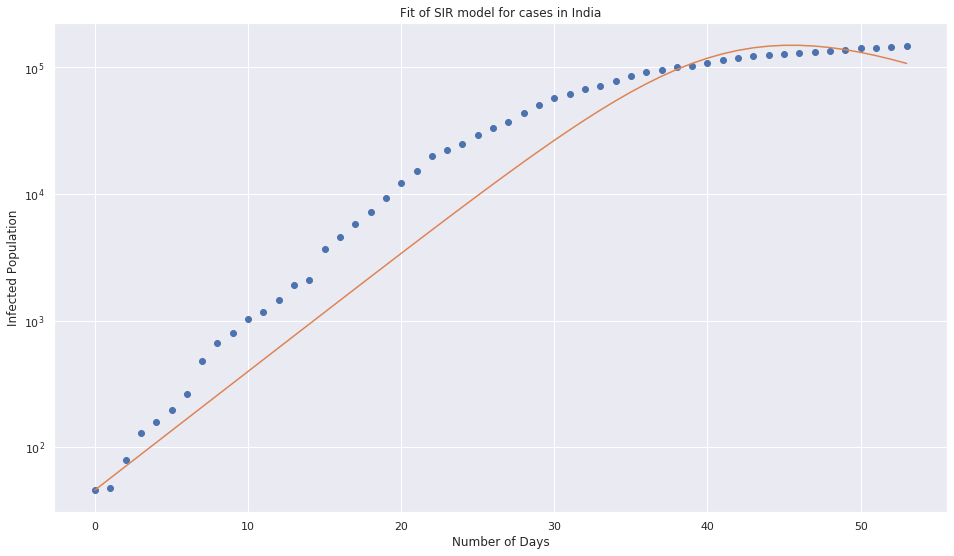

Optimal Parametes: beta =  0.43647987136095434  and gamma =  0.22068799330810332
Reproduction number, R0 :  1.9778143106842392


In [101]:
plt.semilogy(time,ydata, 'o')
plt.semilogy(time, fitted)
plt.title("Fit of SIR model for cases in %s" %country)
plt.ylabel('Infected Population')
plt.xlabel('Number of Days')
plt.show()
print('Optimal Parametes: beta = ', popt[0], ' and gamma = ', popt[1])
print('Reproduction number, R0 : ', popt[0]/popt[1])

# Dynamic beta in SIR (Rate of infection)

In [105]:
t_initial = 50
t_intro_measures = 16
t_hold = 21
t_relax = 21

beta_max = 0.5645
beta_min = 0.11
gamma = 0.2


pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                          np.linspace(beta_max, beta_min, t_intro_measures),
                          np.array(t_hold * [beta_min]),
                          np.linspace(beta_min, beta_max, t_relax)
                        ))

pd_beta

array([0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  , 0.5645  ,
       0.5645  , 0.5645  , 0.5645  , 0.5342  , 0.5039  , 0.4736  ,
       0.4433  , 0.413   , 0.3827  , 0.3524  , 0.3221  , 0.2918  ,
       0.2615  , 0.2312  , 0.2009  , 0.1706  , 0.1403  , 0.11    ,
       0.11    , 0.11    , 0.11    , 0.11    , 0.11    , 0.11    ,
       0.11    , 0.11    , 0.11    , 0.11    , 0.11    , 0.11    ,
       0.11    , 0.11    , 0.11    , 0.11    , 0.11    , 0.11    ,
       0.11    , 0.11    , 0.11    , 0.11    , 0.132725, 0.155

In [106]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each_beta in pd_beta:
    new_delta_vector = SIR_model(SIR, time, each_beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )

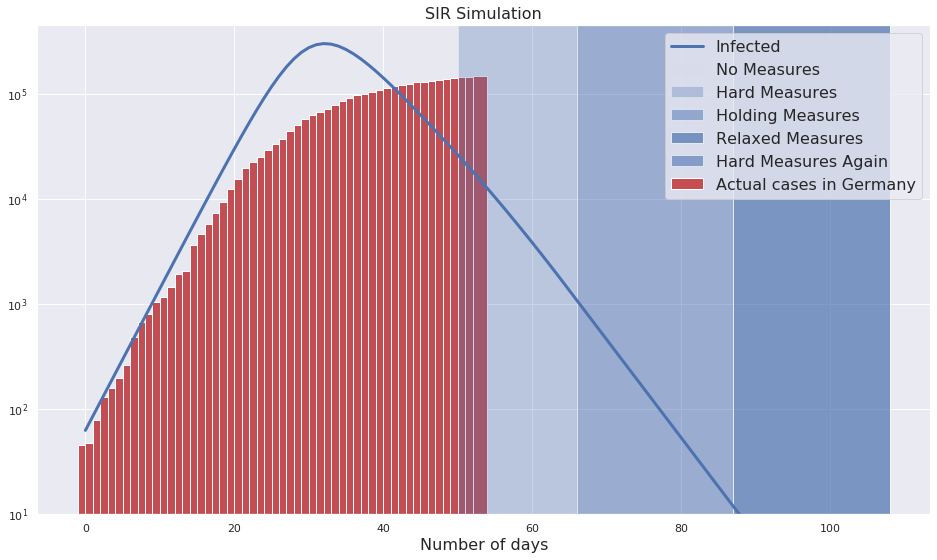

In [107]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', linewidth = 3)

ax1.bar(np.arange(len(ydata)), ydata, width=2, label = 'Actual cases in Germany', color = 'r')
t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()

ax1.axvspan(0, t_phases[0], facecolor='b', alpha=0.01, label="No Measures")
ax1.axvspan(t_phases[0], t_phases[1], facecolor='b', alpha=0.3, label="Hard Measures")
ax1.axvspan(t_phases[1], t_phases[2], facecolor='b', alpha=0.5, label="Holding Measures")
ax1.axvspan(t_phases[2], t_phases[3], facecolor='b', alpha=0.7, label="Relaxed Measures")
ax1.axvspan(t_phases[3], len(propagation_rates.Infected),facecolor='b', alpha=0.6, label="Hard Measures Again")

ax1.set_ylim(10,1.5*max(propagation_rates.Infected))
#ax1.set_xlim(0,100)
ax1.set_yscale('log')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})